In [40]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

In [41]:
def pre_processing(img):
    ret, pipe = cv.threshold(img, 100, 255, cv.THRESH_BINARY_INV)
    return pipe

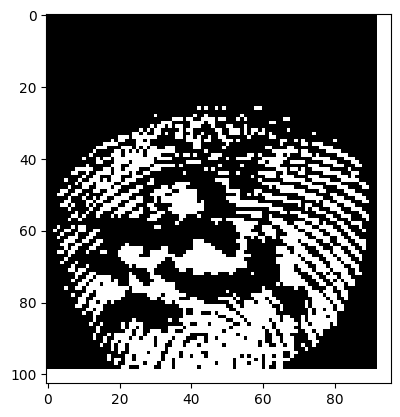

In [42]:
best_score = 0
filename = None
image = None
kp1, kp2, mp = None, None, None
keypoints = 0

file_names = [file for file in os.listdir("../assets/Real")]
sample = pre_processing(cv.imread("../assets/Altered/Altered-Hard/1__M_Left_ring_finger_Obl.BMP"))
plt.imshow(sample, cmap="gray")

In [43]:
for file in file_names[:1000]:
    img = pre_processing(cv.imread("../assets/Real/" + file))
    sift = cv.SIFT_create()

    key_1, des_1 = sift.detectAndCompute(sample, None)
    key_2, des_2 = sift.detectAndCompute(img, None)

    # Apply FLANN-based matching
    matches = cv.FlannBasedMatcher(
        {'algorithm': 1, 'trees': 10}, {}
    ).knnMatch(des_1, des_2, k=2)

    match_points = []
    for i, j in matches:
        if i.distance < 0.8 * j.distance:
            match_points.append(i)

    keypoints = min(len(key_1), len(key_2))

    # Check if match score is higher than the best score
    match_score = len(match_points) / keypoints * 100 if keypoints > 0 else 0
    if match_score > best_score:
        best_score = match_score
        filename = file
        image = img
        kp  = key_1
        kp2 = key_2
        mp  = match_points

# Display the best match
print("BEST MATCH: " + ("No match found" if filename is None else filename))
print("SCORE: " + str(best_score))


BEST MATCH: 156__F_Left_thumb_finger.BMP
SCORE: 31.818181818181817


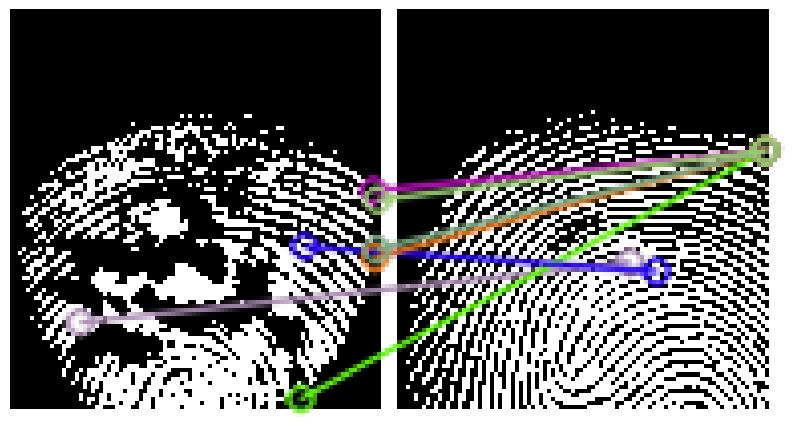

In [44]:
if best_score != 0:
    # Use the correct variables for keypoints and matches
    result = cv.drawMatches(sample, kp, image, kp2, mp, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # result = cv.resize(result, None, fx=4, fy=4)
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')  # Hide axes for a cleaner view
    plt.show()